# Elternleben.de Chatbot Hackathon - Data Exploration

Welcome to the Elternleben.de Chatbot Hackathon Data Exploration Notebook! 👋
 
This notebook is designed to help you explore the dataset and understand the types of conversations, content, and user needs you'll be working with during the challenge. It's designed to help you get familiar with the data structure. Feel free to come up with for your own discoveries and insights.
 
Let's dive in and start exploring the data! 📊

In [7]:
# We will use pandas for data manipulation and matplotlib/seaborn for visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import re
from collections import Counter
import glob
from pathlib import Path
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# For nicer visualizations
plt.style.use('ggplot')
%matplotlib inline

## Challenge Goals and Data Analysis Approach

Before we dive into the data, let's recall the main goals of this hackathon:

### Goal 1: High-quality Conversational Intelligence and User Engagement
- Building an empathetic, engaging conversation flow with personalized responses
- Maintaining context and understanding user needs
- Ensuring high-quality, accurate content recommendations

### Goal 2: Multi-Touchpoint Service Integration
- Creating seamless connections between the chatbot and service ecosystem
- Intelligent routing between automated responses and expert consultations
- Implementing direct scheduling capabilities and analytics tracking

Keep these goals in mind as we explore the data - your analysis should help identify patterns and insights that will support these objectives.

## 1. Loading and Overview of the Data

Let's start by loading the two main datasets: the content metadata and the conversation logs.

In [8]:
# Load metadata and conversation data
metadata = pd.read_csv('metadata.csv')
conversations = pd.read_csv('processed_conversations.csv')

# Display basic information about the datasets
print(f"Content metadata: {len(metadata)} articles")
print(f"Conversation logs: {len(conversations)} messages in {conversations['conversation_id'].nunique()} conversations")

Content metadata: 753 articles
Conversation logs: 253 messages in 135 conversations


In [9]:
# Preview metadata
metadata.head()

,url,filepath,filename,title,description,author,category,crawled_at
0,https://www.elternleben.de/haeufige-fragen/tro...,content/elternleben/haeufige-fragen/trotz-wut.md,trotz-wut.md,Trotz und Wut – Häufige Elternfragen,Die Autonomiephase eines Kindes ist sehr wicht...,NaN,['haeufige-fragen'],2025-03-05T19:44:00.824427
1,https://www.elternleben.de/baby/entwicklung-ba...,content/elternleben/baby/entwicklung-baby/wie-...,wie-du-dein-baby-richtig-traegst.md,Wie du dein Baby richtig trägst - Tipps zur Tr...,"Erfahre, wie du dein Baby im Tragetuch oder in...",Esther Howoldt,"['baby', 'entwicklung-baby']",2025-03-05T19:44:02.115949
2,https://www.elternleben.de/baby/babyschlaf/wie...,content/elternleben/baby/babyschlaf/wie-viel-s...,wie-viel-schlaf-braucht-ein-baby.md,Wie viel Schlaf braucht ein Baby?,Wieviel Schlaf braucht ein Baby in den verschi...,Melanie Schüer,"['baby', 'babyschlaf']",2025-03-05T19:44:04.160184
3,https://www.elternleben.de/erziehung-und-foerd...,content/elternleben/erziehung-und-foerderung/k...,kind-ist-schuechtern.md,Warum ist mein Kind so schüchtern?,Mein Kind ist schüchtern. Es möchte nichts Neu...,Melanie Schüer,['erziehung-und-foerderung'],2025-03-05T19:44:05.574111
4,https://www.elternleben.de/baby/gesundes-baby/...,content/elternleben/baby/gesundes-baby/baby-ha...,baby-hat-schnupfen.md,Baby hat Schnupfen und verstopfte Nase – Was tun?,"Wenn das Baby Schnupfen hat, kann es auch für ...",Dr. Nikola Klün,"['baby', 'gesundes-baby']",2025-03-05T19:44:05.927799


In [10]:
# Preview conversations
conversations.head()

,conversation_id,conversation_start,request_timestamp,response_timestamp,user_message,chatbot_response,response_links,needs_escalation,recommended_approach
0,21,2024-11-08T13:20:33.399Z,"Fri Nov 8, 2024 1:10pm","Fri Nov 8, 2024 1:11pm",Mein Kind hat Angst vorm Kindergarten,"Es ist ganz normal, dass Kinder Angst vor dem ...",https://www.elternleben.de/haeufige-fragen/kit...,NaN,NaN
1,22,2024-11-08T15:50:32.278Z,"Fri Nov 8, 2024 3:41pm","Fri Nov 8, 2024 3:41pm",Ausraster mir hauen und Gegenstände werfen,"Es ist ganz normal, dass Kinder manchmal Wutan...",https://www.elternleben.de/elternwissen/kleink...,NaN,NaN
2,22,2024-11-08T15:50:32.278Z,"Fri Nov 8, 2024 3:42pm","Fri Nov 8, 2024 3:42pm",Das passiert meist in der Schule,"Es kann sehr herausfordernd sein, wenn ein Kin...",https://www.elternleben.de/haeufige-fragen/tro...,NaN,NaN
3,22,2024-11-08T15:50:32.278Z,"Fri Nov 8, 2024 3:43pm","Fri Nov 8, 2024 3:43pm",Vielen Dank,Gern geschehen! 😊 Wenn du noch weitere Fragen ...,NaN,NaN,NaN
4,22,2024-11-08T15:50:32.278Z,"Fri Nov 8, 2024 3:43pm","Fri Nov 8, 2024 3:43pm",Lieben Dank dir auch alles gute,Vielen Dank! 😊 Pass gut auf dich auf und bis b...,NaN,NaN,NaN


## 2. Understanding Content Structure and Distribution

Let's analyze the content metadata to understand what types of content are available, how they're organized, and which topics are most common.

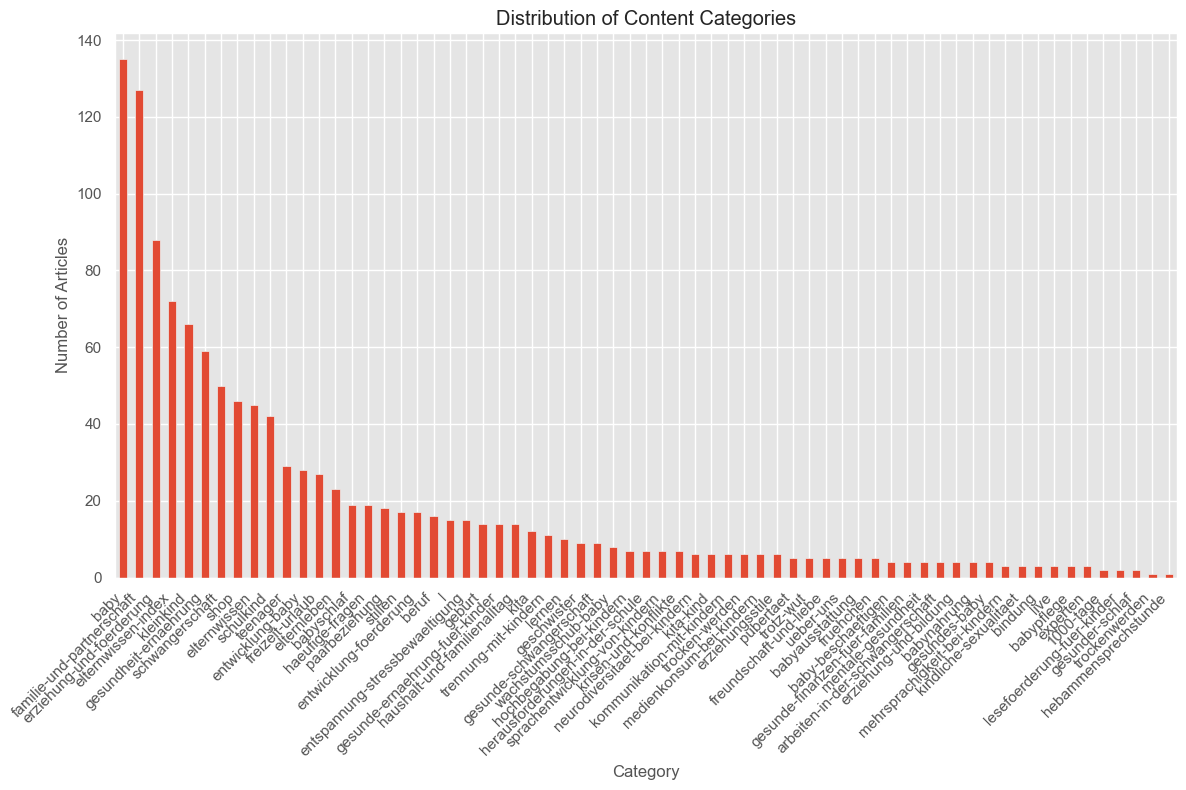

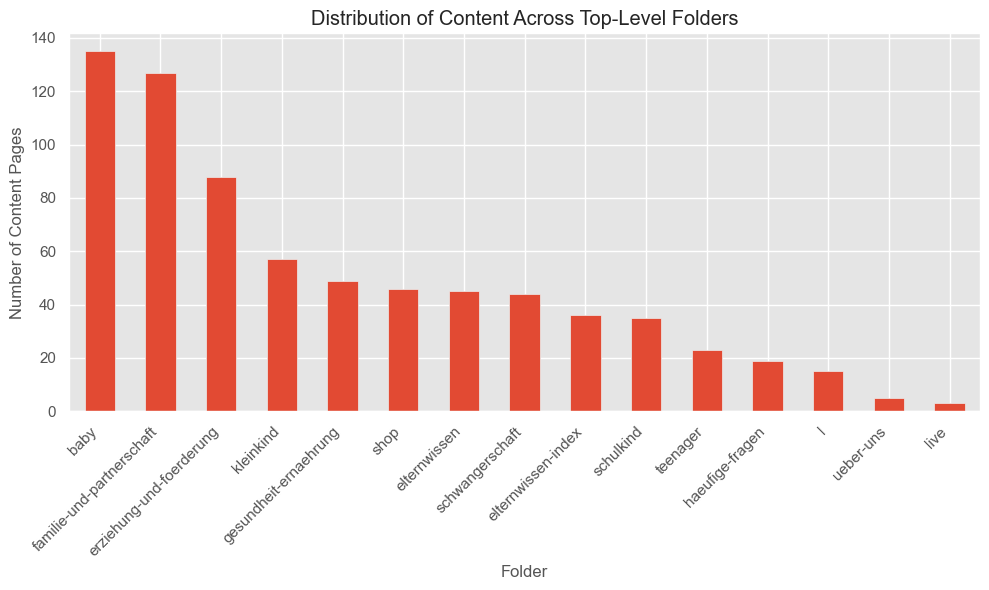

In [21]:
# Look at the distribution of content categories
# Extract categories from the array and count them
# Since category is an array, we need to flatten it first
all_categories = []
for cat_list in metadata['category']:
    # Convert string representation of list to actual list
    if isinstance(cat_list, str):
        # Remove brackets and quotes, then split by comma
        categories = cat_list.strip('[]').replace("'", "").split(', ')
        all_categories.extend(categories)

# Count occurrences of each category
category_counts = pd.Series(all_categories).value_counts()

# Visualize the category distribution
plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar')
plt.title('Distribution of Content Categories')
plt.ylabel('Number of Articles')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Examine the hierarchy structure based on filepaths
def get_top_level_folder(filepath):
    parts = filepath.split('/')
    # General top folders are called "content" and "elternleben": content/elternleben/...
    # That's why always return the third element
    return parts[2] if len(parts) > 0 else None

metadata['top_folder'] = metadata['filepath'].apply(get_top_level_folder)
top_folders = metadata['top_folder'].value_counts()

# Visualize the distribution
plt.figure(figsize=(10, 6))

# Top 15 folders
top_folders.head(15).plot(kind='bar')
plt.title('Distribution of Content Across Top-Level Folders')
plt.ylabel('Number of Content Pages')
plt.xlabel('Folder')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We see some categories and top-level folders with transparent names. However, something catches my eye -- what is this 'l' folder?

After I look it up in the content base, apparently it contains articles with consultation offers for different cases. Feel free to look it up as well.

### Further exploration ideas:
- How does the content distribution vary across different categories?
- Are there patterns in how the content is organized?
- What are the most common topics covered in the content?


### 2.1. Understanding Content Files.

Let's explore a sample of the content files to understand their structure:

In [27]:
# Function to read markdown files
def read_markdown_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read()

# Get a list of a few sample markdown files
content_files = glob.glob("content/**/*.md", recursive=True)
print(f"Total content files found: {len(content_files)}")

# Let's look at the structure of a sample file (feel free to change the index)
if content_files:
    sample_file = content_files[42]
    print(f"\nSample file: {sample_file}")
    content = read_markdown_file(sample_file)
    
    # Display the markdown file
    print("\nFile content:")
    print(content)
    
    # Check for metadata section
    metadata_match = re.search(r'---\n(.*?)\n---', content, re.DOTALL)
    if metadata_match:
        print("\nMetadata section found:")
        print(metadata_match.group(1))

Total content files found: 753

Sample file: content/elternleben/schwangerschaft/geburt/wochenbettdepression.md

File content:
---
author: ''
category:
- schwangerschaft
- geburt
crawled_at: '2025-03-05T19:56:38.563120'
description: Wie geht es Dir? Gefühlschaos nach der Geburt. Hier findet Ihr einen
  Überblick über die Gefühle, die junge Mütter und Väter eines Babys häufig verspüren
filename: wochenbettdepression.md
filepath: elternleben/schwangerschaft/geburt/wochenbettdepression.md
title: 'Wenn das Glück ausbleibt: Anzeichen & Hilfe bei Wochenbettdepression'
url: https://www.elternleben.de/schwangerschaft/geburt/wochenbettdepression/
---

#  Wenn das Glück ausbleibt: Anzeichen & Hilfe bei Wochenbettdepression

Die Geburt eines Kindes bringt unzählige Veränderungen mit sich. Neben Glück
und Freude können sich auch Gefühle einstellen, die irritierend sind und dich
verunsichern. Viele Mütter leiden nach der Geburt darunter, dass sie nicht
sofort rundum glücklich sind. Dabei ist es völ

## Further Exploration Ideas for Participants:
- What are the common themes or topics across the content files?
- How is the content structured (headings, paragraphs, lists, etc.)?

## 3. Conversation Data Exploration

Now let's look at the conversation data to understand the basic patterns and the types of interactions between users and the chatbot.

User message length statistics:
count    253.000000
mean       9.201581
std       15.633795
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max      210.000000
Name: user_message_length, dtype: float64

Chatbot response length statistics:
count    253.000000
mean     134.079051
std       78.890682
min        4.000000
25%       48.000000
50%      153.000000
75%      197.000000
max      356.000000
Name: bot_response_length, dtype: float64


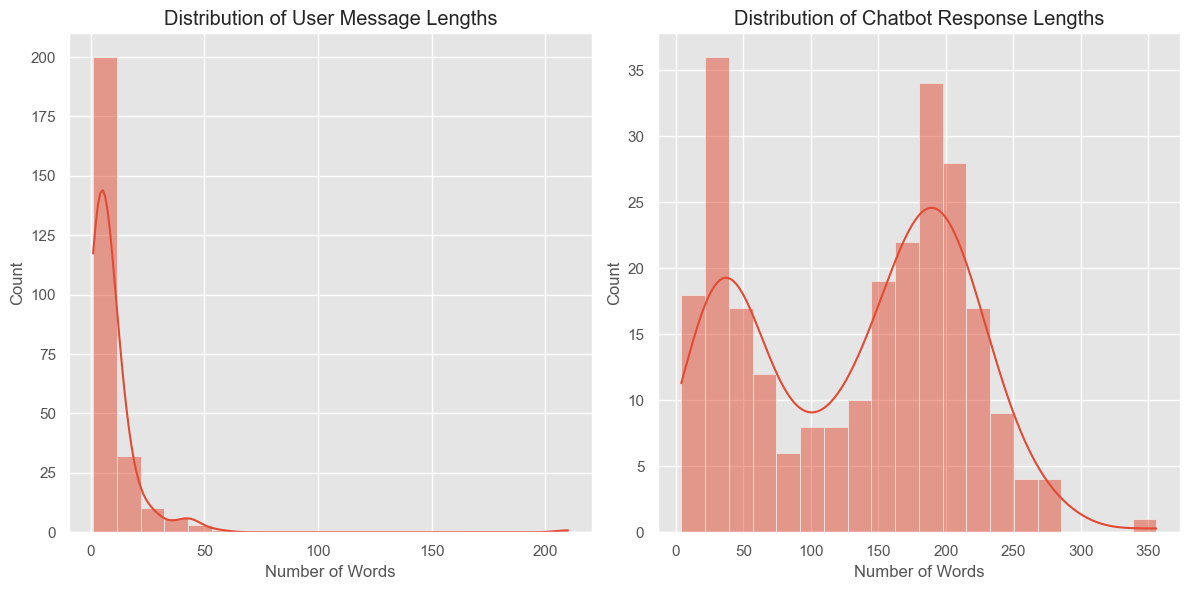

In [22]:
conversations['user_message_length'] = conversations['user_message'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
conversations['bot_response_length'] = conversations['chatbot_response'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Basic statistics on message lengths
print("User message length statistics:")
print(conversations['user_message_length'].describe())

print("\nChatbot response length statistics:")
print(conversations['bot_response_length'].describe())

# Plot the distribution of message lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(conversations['user_message_length'], bins=20, kde=True)
plt.title('Distribution of User Message Lengths')
plt.xlabel('Number of Words')

plt.subplot(1, 2, 2)
sns.histplot(conversations['bot_response_length'], bins=20, kde=True)
plt.title('Distribution of Chatbot Response Lengths')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()

### Further exploration Ideas:
- What are the common patterns in user queries?
- What types of responses lead to successful interactions vs. those requiring escalation?
- Is there a correlation between message length and the need for escalation?
- How do different conversation categories (information-seeking, problem-solving, etc.) relate to recommended approaches?